In [1]:
import matplotlib.pyplot as plt

# Create a gallery and query set

The *gallery* contains the images that are used as a reference. We know the class name of each image in the gallery. The images in the *query* set will be compared with the images in the gallery. We can predict the class name of a query by looking for the best match in the gallery.

In [2]:
from lib.soda_dataset import get_gallery_and_queries

gallery, queries, gallery_labels, query_labels = get_gallery_and_queries()

# Visualize the opponent color histogram of each gallery image

If you want an interactive 3D-plot, uncomment `%matplotlib notebook` in the notebook cell below.

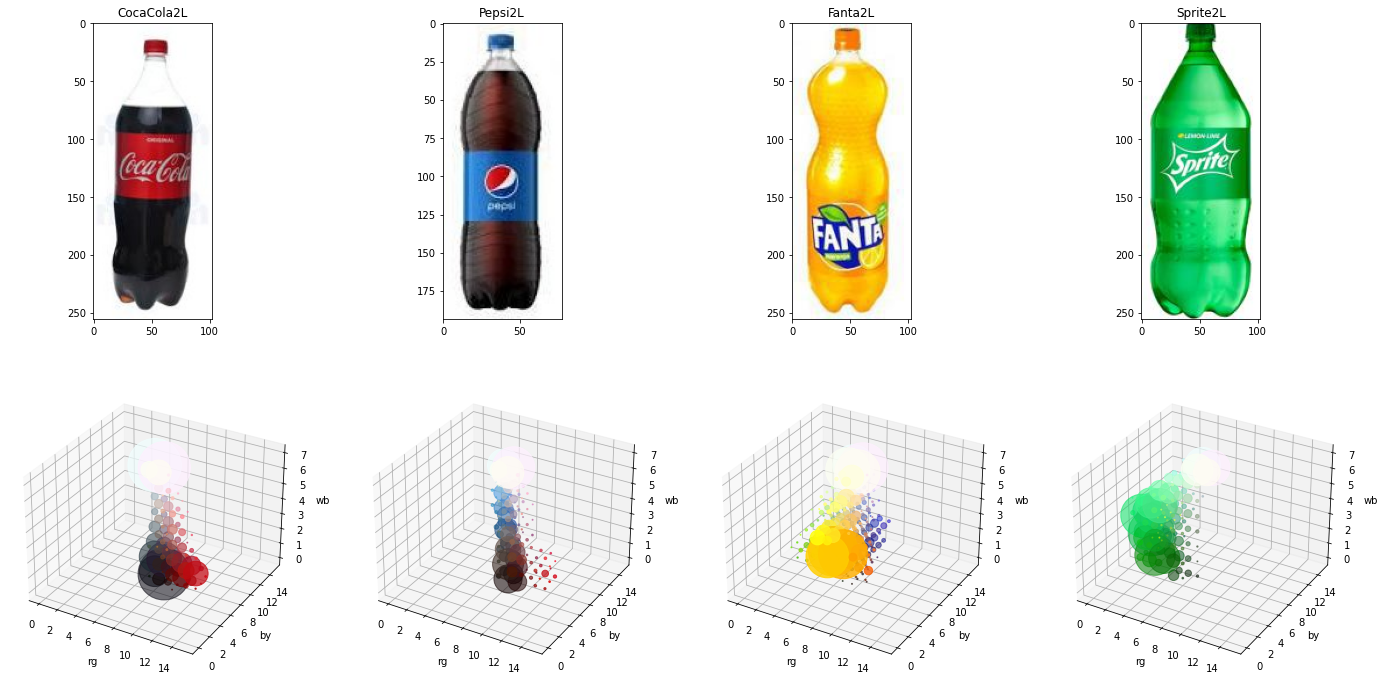

In [3]:
# %matplotlib notebook

from lib.histogram_comparison import calc_opp_color_hist, plot_imgs_with_opp_color_hist

# Calculate the opponent histogram of each gallery image
g_hists = [calc_opp_color_hist(img) for img in gallery]

# Visualize
plot_imgs_with_opp_color_hist(gallery, g_hists, gallery_labels)

# Calculate a similarity matrix using opponent histograms

To find the matches, we first calculate a **similarity matrix**. This contains the similarity between each possible gallery-query pair.

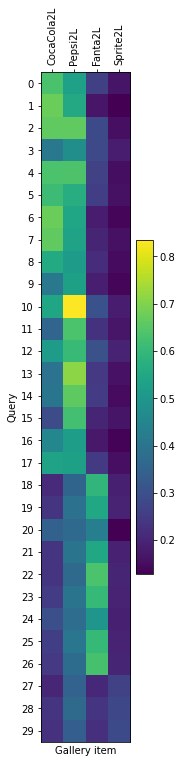

In [4]:
from lib.histogram_comparison import match_opp_color_hist
from lib.plots import plot_sim_mat

sim_mat = match_opp_color_hist(gallery, queries)

plot_sim_mat(sim_mat, gallery_labels)

As you can see, each row in the similarity matrix has the **same amount of rows as the number of queries** and the **same amount of columns as the number of gallery items**.

# Find the best match for each query

The best match is the match with the highest similarity score. With `argmax(axis=1)`, we obtain for each query the index of the gallery item with the highest similarity score. We need to use `axis=1`, because we want the maximum over the columns.

In [5]:
match_idxs = sim_mat.argmax(axis=1)

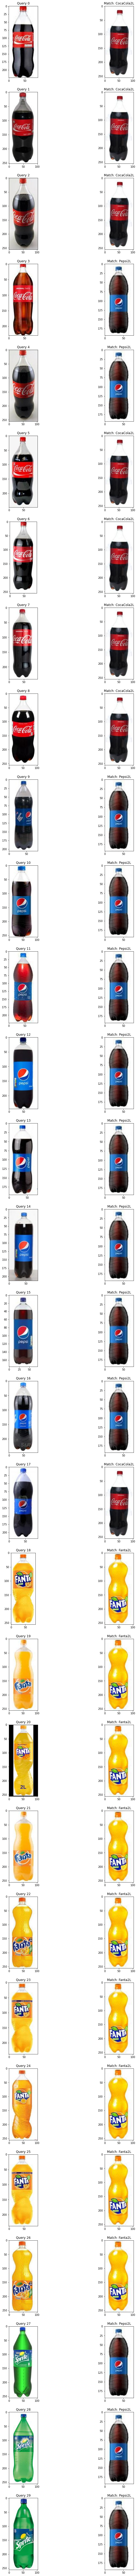

In [6]:
from lib.plots import plot_matches

plot_matches(gallery, queries, match_idxs, gallery_labels)

# Evaluate the results

See [2_evaluation_metrics.ipynb](./2_evaluation_metrics.ipynb) for more details.

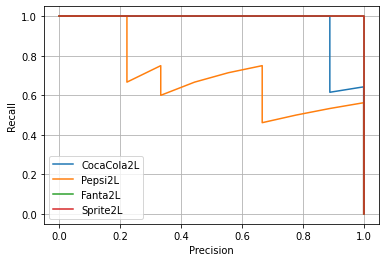

In [7]:
from lib.plots import plot_pr_curves

plot_pr_curves(sim_mat, gallery_labels, query_labels)

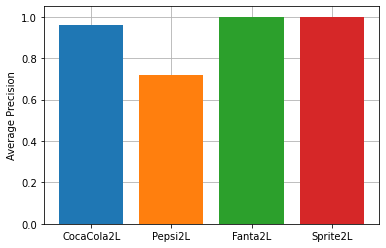

In [8]:
from lib.plots import plot_aps

plot_aps(sim_mat, gallery_labels, query_labels)